In [4]:
import torch
import torch.utils.data as data
from pathlib import Path
from PIL import Image
import numpy as np
import json

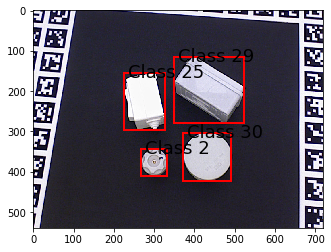

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import ToTensor


class TLessRealDataset(data.Dataset):
    """Provides access to images, bboxes and classids for TLess real dataset.
    
    Download dataset
    https://bop.felk.cvut.cz/datasets/#T-LESS
    http://ptak.felk.cvut.cz/6DB/public/bop_datasets/tless_test_primesense_bop19.zip
    
    Format description 
    https://github.com/thodan/bop_toolkit/blob/master/docs/bop_datasets_format.md

    
    
    """
    def __init__(self, basepath, image_transform=None):
        self.basepath = Path(basepath)
        self.image_transform = image_transform
        assert self.basepath.exists()
        
        # 000001, 000002,...
        self.all_rgbpaths = []
        self.all_bboxes = []
        self.all_clsids = []
        
        scenes = [f for f in self.basepath.iterdir() if f.is_dir()]
        for scenepath in scenes:
            with open(scenepath / 'scene_gt.json', 'r') as fp:
                scene_gt = json.loads(fp.read())
            with open(scenepath / 'scene_gt_info.json', 'r') as fp:
                scene_gt_info = json.loads(fp.read())
                
            for idx in scene_gt.keys():
                rgbpath = scenepath / 'rgb' / f'{int(idx):06d}.png'
                assert rgbpath.exists()
                
                clsids = [int(e['obj_id']) for e in scene_gt[idx]]
                bboxes = [e['bbox_obj'] for e in scene_gt_info[idx]]
                
                self.all_rgbpaths.append(rgbpath)
                self.all_bboxes.append(np.array(bboxes))
                self.all_clsids.append(np.array(clsids))
                
    def __len__(self):
        return len(self.all_rgbpaths)
    
    def __getitem__(self, idx):
        img = Image.open(str(self.all_rgbpaths[idx])).convert('RGB')        
        if self.image_transform is not None:
            img = self.image_transform(img)
        return img, self.all_bboxes[idx], self.all_clsids[idx]

        
ds = TLessRealDataset(r'C:\data\tless_test_primesense_bop19\test_primesense', image_transform=ToTensor())
dl = data.DataLoader(ds, batch_size=1) # batch_size=1 recommended, according to docs images are variably cropped.

img, bboxes, cids = next(iter(dl))

fig, axs = plt.subplots()
axs.imshow(img[0].permute(1,2,0), origin='upper')
for cid, bbox in zip(cids[0],bboxes[0]):
    rect = patches.Rectangle(bbox[:2],bbox[2],bbox[3],linewidth=2,edgecolor='r',facecolor='none')
    axs.add_patch(rect)
    axs.text(bbox[0]+10, bbox[1]+10, f'Class {cid.item()}', fontsize=18)
plt.show()

